# 1.加载模块

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras.layers.core import Reshape, Permute
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import LSTM, GRU
from keras.utils.vis_utils import plot_model

import keras
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 960 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 6021)
D:\Anaconda2\lib\site-packages\theano\sandbox\cuda\__init__.py:631: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn(warn)


### 写一个LossHistory类，保存loss和acc

In [2]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
        
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
        
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc', ls='-')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss', ls='--')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc', ls='-.')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss', ls=':')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

history = LossHistory()

# 2. 变量初始化

In [3]:
batch_size = 32
nb_classes = 6
nb_epochs = 200



img_rows, img_cols = 72, 72
img_channels = 1

img_timesteps = 30

train_samples = 360
val_samples = 30
test_samples = 60

nb_lstm_outputs = 15

# 3. 加载数据

In [4]:
pkl_file = open('data_final_nps.pkl', 'rb')
my_data = pickle.load(pkl_file)
my_label = pickle.load(pkl_file)
pkl_file.close()
print 'original data shape:', my_data.shape


x_train_1 = my_data[0:240, :, :, :, :]
y_train_1 = my_label[0:240]		# 8 day person 
x_train_2 = my_data[330:450, :, :, :, :]
y_train_2 = my_label[330:450]	# 4 night person 
x_train = np.concatenate((x_train_1, x_train_2), axis=0)
y_train = np.concatenate((y_train_1, y_train_2), axis=0)	# 12 person for train

x_val = my_data[270:300, :, :, :, :]
y_val = my_label[270:300]									# 1 day person for val

x_test_1 = my_data[240:270, :, :, :, :]
y_test_1 = my_label[240:270]	# 1 day person
x_test_2 = my_data[300:330, :, :, :, :]
y_test_2 = my_label[300:330]		# 1 night person
x_test = np.concatenate((x_test_1, x_test_2), axis=0)
y_test = np.concatenate((y_test_1, y_test_2), axis=0)		# 2 person for test





y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_val = np.reshape(y_val, (y_val.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))

#x_train = 255 * np.random.random((train_samples, img_timesteps, img_channels, img_rows, img_cols))
#y_train = np.random.randint(nb_classes, size=(train_samples, 1))
#x_test = 255 * np.random.random((val_samples, img_timesteps, img_channels, img_rows, img_cols))
#y_test = np.random.randint(nb_classes, size=(val_samples, 1))


#x_train = np.uint8(x_train)
#x_test = np.uint8(x_test)
#y_train = np.uint8(y_train)
#y_test = np.uint8(y_test)


Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_val = np_utils.to_categorical(y_val, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

#X_train = np.reshape(x_train, (-1, img_channels, img_rows, img_cols))
#X_test = np.reshape(x_test, (-1, img_channels, img_rows, img_cols))


print 'train data shape: ', x_train.shape
print 'val data shape: ', x_val.shape
print 'test data shape: ', x_test.shape
print 'train label shape: ', Y_train.shape
print 'val label shape: ', Y_val.shape
print 'test label shape: ', Y_test.shape

original data shape: (450L, 30L, 1L, 72L, 72L)
train data shape:  (360L, 30L, 1L, 72L, 72L)
val data shape:  (30L, 30L, 1L, 72L, 72L)
test data shape:  (60L, 30L, 1L, 72L, 72L)
train label shape:  (360L, 6L)
val label shape:  (30L, 6L)
test label shape:  (60L, 6L)


# 4. 搭建模型

In [6]:
model = Sequential()

#cnn
model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same'), 
                 input_shape=(img_timesteps, img_channels, img_rows, img_cols)))
model.add(Activation('relu'))
#model.add(TimeDistributed(Conv2D(8, (3, 3), padding='same')))
#model.add(Activation('relu'))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(Dropout(0.5))

#model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same')))
#model.add(Activation('relu'))
model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
model.add(Activation('relu'))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(Dropout(0.5))

#model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
#model.add(Activation('relu'))
#model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same')))
#model.add(Activation('relu'))
#model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))


#model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same')))
#model.add(Activation('relu'))
#model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same')))
#model.add(Activation('relu'))
#model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
#model.add(Dropout(0.5))


model.add(TimeDistributed(Flatten()))
#model.add(Reshape((50, 10240)))
model.add(GRU(nb_lstm_outputs))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))


model.summary()
#plot_model(model, to_file='my_cnn_lstm_model.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_6 (TimeDist (None, 30, 16, 72, 72)    160       
_________________________________________________________________
activation_4 (Activation)    (None, 30, 16, 72, 72)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 16, 36, 36)    0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 16, 36, 36)    0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 30, 32, 36, 36)    4640      
_________________________________________________________________
activation_5 (Activation)    (None, 30, 32, 36, 36)    0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 30, 32, 18, 18)    0         
__________

# 5. 编译及训练

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, Y_train, batch_size=batch_size, epochs=nb_epochs, 
          verbose=2, shuffle=True, validation_data=(x_val, Y_val),
          callbacks=[history])

1 #include <Python.h>
2 #include <iostream>
3 #include "theano_mod_helper.h"
4 #include "cuda_ndarray.cuh"
5 #include <math.h>
6 #include <numpy/arrayobject.h>
7 #include <numpy/arrayscalars.h>
8 #include "cudnn.h"
9 #include "cudnn_helper.h"
10 //////////////////////
11 ////  Support Code
12 //////////////////////
13 
14 void _capsule_destructor(PyObject *o) {
15     void *d = PyCapsule_GetContext(o);
16     void *p = PyCapsule_GetPointer(o, NULL);
17     void (*f)(void *) = (void (*)(void *))d;
18     if (f != NULL) f(p);
19 }
20 
21 
22 static cudnnHandle_t _handle = NULL;
23 
24 
25 static int
26 c_set_tensorNd(CudaNdarray *var, cudnnTensorDescriptor_t desc) {
27 
28   int dim = CudaNdarray_NDIM(var);
29   int *strides = (int *)malloc(dim * sizeof(int));
30   int default_str = 1;
31   int return_value = 0;
32   
33   if (strides != NULL) {
34     for (int i = dim-1; i >= 0; i--)
35     {
36       if (CudaNdarray_HOST_STRIDES(var)[i])
37         strides[i] = CudaNdarray_HOST_STRIDES

mod.cu

['nvcc', '-shared', '-O3', '-LD:\\Anaconda2\\libs', '-use_fast_math', '-arch=sm_52', '--compiler-bindir', 'C:\\Program Files (x86)\\Microsoft Visual Studio 12.0\\VC\\bin', '-Xlinker', '/DEBUG', '-D HAVE_ROUND', '-m64', '-Xcompiler', '-DCUDA_NDARRAY_CUH=c72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,/Zi,/MD', '-I"C:\\Users\\aaron_wu\\AppData\\Local\\Theano\\compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-2.7.13-64\\cuda_ndarray"', '-I"D:\\Anaconda2\\lib\\site-packages\\theano\\sandbox\\cuda"', '-I"D:\\Anaconda2\\lib\\site-packages\\numpy\\core\\include"', '-I"D:\\Anaconda2\\include"', '-I"D:\\Anaconda2\\lib\\site-packages\\theano\\gof"', '-L"C:\\Users\\aaron_wu\\AppData\\Local\\Theano\\compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-2.7.13-64\\cuda_ndarray"', '-L"D:\\Anaconda2\\libs"', '-L"D:\\Anaconda2"', '-o', 'C:\\Users\\aaron_wu\\AppData\\Local\\Theano\\compiledir_Windows-10-1

674 if (APPLY_SPECIFIC(output) != NULL)
675   cudnnDestroyTensorDescriptor(APPLY_SPECIFIC(output));
676 if (APPLY_SPECIFIC(kerns) != NULL)
677   cudnnDestroyFilterDescriptor(APPLY_SPECIFIC(kerns));
678 
679 #undef DTYPE_INPUT_0
680 #undef TYPENUM_INPUT_0
681 #undef ITEMSIZE_INPUT_0
682 #undef DTYPE_INPUT_1
683 #undef TYPENUM_INPUT_1
684 #undef ITEMSIZE_INPUT_1
685 #undef DTYPE_INPUT_2
686 #undef TYPENUM_INPUT_2
687 #undef ITEMSIZE_INPUT_2
688 #undef DTYPE_INPUT_4
689 #undef TYPENUM_INPUT_4
690 #undef ITEMSIZE_INPUT_4
691 #undef DTYPE_INPUT_5
692 #undef TYPENUM_INPUT_5
693 #undef ITEMSIZE_INPUT_5
694 #undef DTYPE_OUTPUT_0
695 #undef TYPENUM_OUTPUT_0
696 #undef ITEMSIZE_OUTPUT_0
697 #undef APPLY_SPECIFIC
698 #undef CONV_ALGO
699 #undef CHOOSE_ALGO
700 #undef CHOOSE_ALGO_ONCE
701 #undef CHOOSE_ALGO_TIME
702 #undef CONV_INPLACE
703 double __DUMMY_16;
704 
705             Py_XDECREF(this->storage_V3);
706 Py_XDECREF(this->storage_V5);
707 Py_XDECREF(this->storage_V7);
708 Py_XDECREF(this->s

Exception: ('The following error happened while compiling the node', GpuDnnConv{algo='small', inplace=True}(GpuContiguous.0, GpuContiguous.0, GpuAllocEmpty.0, GpuDnnConvDesc{border_mode='half', subsample=(1, 1), conv_mode='conv', precision='float32'}.0, Constant{1.0}, Constant{0.0}), '\n', 'nvcc return status', 2, 'for cmd', 'nvcc -shared -O3 -LD:\\Anaconda2\\libs -use_fast_math -arch=sm_52 --compiler-bindir C:\\Program Files (x86)\\Microsoft Visual Studio 12.0\\VC\\bin -Xlinker /DEBUG -D HAVE_ROUND -m64 -Xcompiler -DCUDA_NDARRAY_CUH=c72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,/Zi,/MD -I"C:\\Users\\aaron_wu\\AppData\\Local\\Theano\\compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-2.7.13-64\\cuda_ndarray" -I"D:\\Anaconda2\\lib\\site-packages\\theano\\sandbox\\cuda" -I"D:\\Anaconda2\\lib\\site-packages\\numpy\\core\\include" -I"D:\\Anaconda2\\include" -I"D:\\Anaconda2\\lib\\site-packages\\theano\\gof" -L"C:\\Users\\aaron_wu\\AppData\\Local\\Theano\\compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-2.7.13-64\\cuda_ndarray" -L"D:\\Anaconda2\\libs" -L"D:\\Anaconda2" -o C:\\Users\\aaron_wu\\AppData\\Local\\Theano\\compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-2.7.13-64\\tmpv4nxyr\\ea4e203b6529466794536f8a1bfa77ae.pyd mod.cu -lcudart -lcublas -lcuda_ndarray -lcudnn -lpython27', "[GpuDnnConv{algo='small', inplace=True}(<CudaNdarrayType(float32, (False, True, False, False))>, <CudaNdarrayType(float32, 4D)>, <CudaNdarrayType(float32, 4D)>, <CDataType{cudnnConvolutionDescriptor_t}>, Constant{1.0}, Constant{0.0})]")

# 6. 预测

In [8]:
preds   = model.predict(x_test)

index_preds = np.argmax(preds, axis=1)
print 'predict label: ', index_preds
y_test = np.reshape(y_test, (y_test.shape[0],))
print 'true label:', y_test
print 'test acc:', (y_test == index_preds).mean()

predict label:  [5 5 1 1 1 1 1 1 1 5 5 1 5 5 5 5 5 5 1 1 1 1 1 1 5 5 1 1 1 5 5 5 5 5 4 4 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
true label: [0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0
 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5]
test acc: 0.15


# 7. 绘制曲线

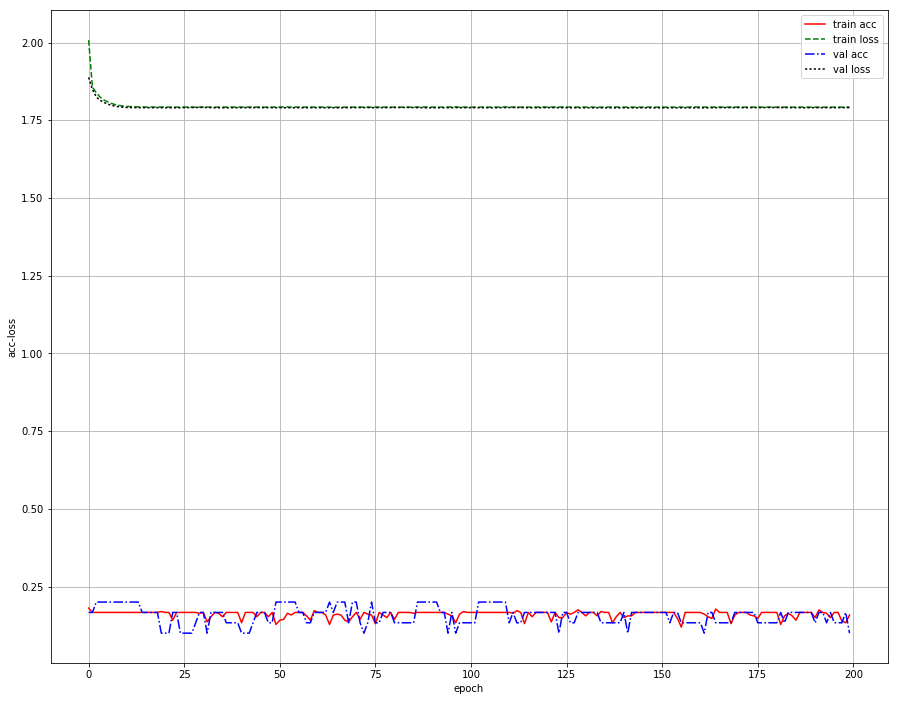

In [9]:
history.loss_plot('epoch')

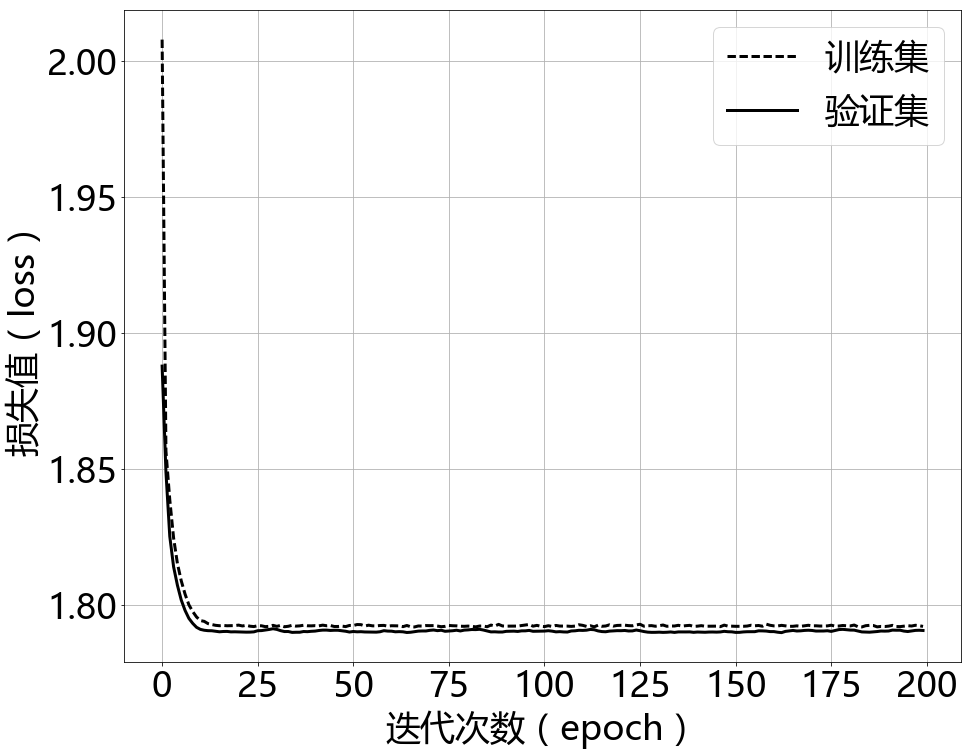

In [10]:
# 仅绘制loss

#-*- coding: utf-8 -*-

myfont = mpl.font_manager.FontProperties(fname='.\msyh.ttc', size=35)
mpl.rcParams['axes.unicode_minus'] = False


prop = {'size' : 35}
iters = range(len(history.losses['epoch']))
plt.plot(iters, history.losses['epoch'], 'k', label=u'训练集', ls='--', linewidth=3)
plt.plot(iters, history.val_loss['epoch'], 'k', label=u'验证集', ls='-', linewidth=3)
plt.grid(True)
plt.xlabel(u'迭代次数（epoch）', fontproperties=myfont)
plt.xticks(fontproperties=myfont)
plt.yticks(fontproperties=myfont)
plt.ylabel(u'损失值（loss）', fontproperties=myfont)
#plt.title(u'损失值曲线',fontproperties=myfont, fontsize=35) 
plt.legend(loc="upper right", prop=myfont)
plt.savefig('day_night_loss.jpg')
plt.show()

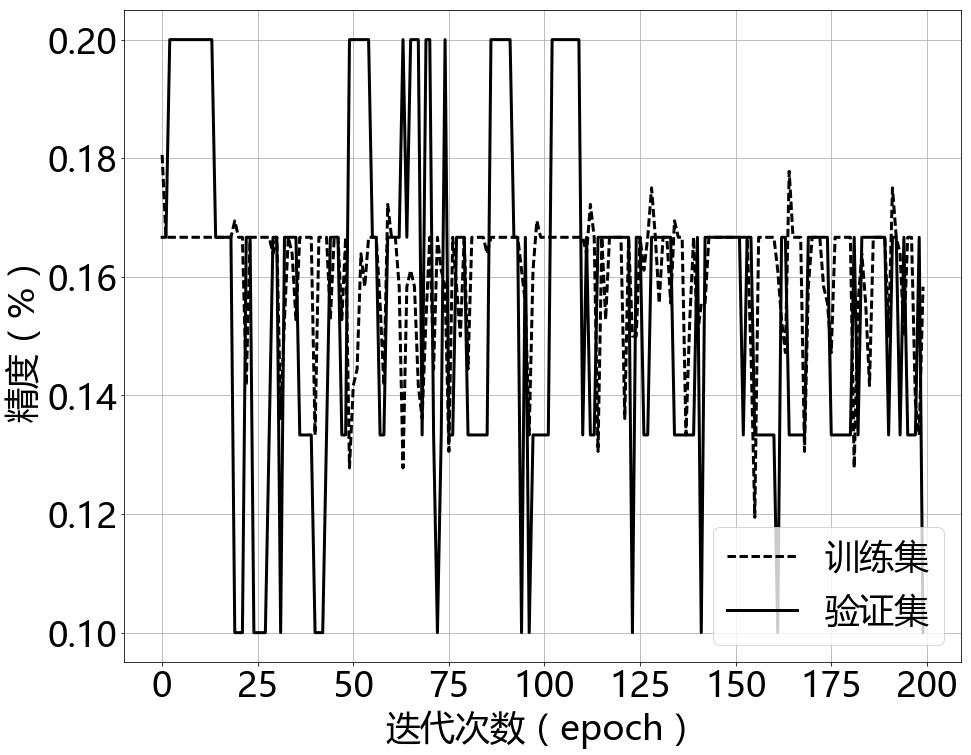

In [11]:
# 仅绘制acc

#-*- coding: utf-8 -*-

myfont = mpl.font_manager.FontProperties(fname='.\msyh.ttc', size=35)
mpl.rcParams['axes.unicode_minus'] = False


prop = {'size' : 35}
iters = range(len(history.accuracy['epoch']))
iters2 = range(len(history.val_acc['batch']))
plt.plot(iters, history.accuracy['epoch'], 'k', label=u'训练集', ls='--', linewidth=3)
plt.plot(iters, history.val_acc['epoch'], 'k', label=u'验证集', ls='-', linewidth=3)
plt.grid(True)
plt.xlabel(u'迭代次数（epoch）', fontproperties=myfont)
plt.ylabel(u'精度（%）', fontproperties=myfont)
plt.xticks(fontproperties=myfont)
plt.yticks(fontproperties=myfont)
#plt.title(u'精度曲线',fontproperties=myfont, fontsize=35) 
plt.legend(loc="lower right", prop=myfont)
plt.savefig('day_night_acc.jpg')
plt.show()